In [69]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [70]:
def load_imdb_data():
    from keras.datasets import imdb
    (train_data, train_labels), (test_data, test_labels) = imdb.load_data()

    word_index = imdb.get_word_index()
    reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

    train_reviews = [' '.join([reverse_word_index.get(i - 3, '?') for i in review]) for review in train_data]
    test_reviews = [' '.join([reverse_word_index.get(i - 3, '?') for i in review]) for review in test_data]

    train_df = pd.DataFrame({"review": train_reviews, "label": train_labels})
    test_df = pd.DataFrame({"review": test_reviews, "label": test_labels})

    return pd.concat([train_df, test_df]).reset_index(drop=True)


In [71]:
def get_movie_genres(movie_id):
    ia = IMDb()
    movie = ia.get_movie(movie_id)
    return movie.get('genres', [])

In [72]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def preprocess_text(text):
    # Remove special characters and numbers
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize text into words
    words = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join words back into a string
    text = ' '.join(words)
    
    return text

In [73]:
imdb_data = load_imdb_data()

In [74]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  50000 non-null  object
 1   label   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


In [75]:
imdb_data['review'] = imdb_data['review'].apply(preprocess_text)

In [124]:
def label_data(row):
    keywords = {
        "other": [],
        "funny": ["comedy",
    "humor",
    "wit",
    "satire",
    "parody",
    "joke",
    "prank",
    "playful",
    "entertaining",
    ],
        "scary": ["horror",
    "terror",
    "fear",
    "dread",
    "shock",
    "spooky",
    "haunting",
    "eerie",
    "creepy",
    "frightening",
    "disturbing",
    "chilling",
    "macabre",
    "gory",
    "bloodcurdling",
    "terrifying",
    "horrifying",
    "gothic",
    "sinister",
    "malevolent",
    "ominous",
    "nightmarish",
    "supernatural",
    "paranormal",
    "psychological",
    "slasher",
    "zombie",
    "monster",
    "demon",
    "ghost",
    "witch",
    "vampire",
    "werewolf",
    "scream",
    "jump scare",
    "horror movie",
    "haunted house",
    "horror novel",
    "horror game",
    "psychological thriller"],
        "dramatic": ["drama",
    "intense",
    "serious",
    "emotional",
    "gripping",
    "powerful",
    "poignant",
    "heart-wrenching",
    "heartfelt",
    "compelling",
    "profound",
    "deep",
    "meaningful",
    "thought-provoking",
    "insightful",
    "touching",
    "moving",
    "tragic",
    "melancholy",
    "sorrowful",
    "heavy",
    "profound",
    "probing",
    "triumphant",
    "uplifting",
    "inspiring",
    "motivational",
    "empathetic",
    "sensitive",
    "emotive",
    "soulful",
    "stirring",
    "resonant",
    "gripping",
    "engrossing",
    "character-driven",
    "emotionally charged",
    "powerful performances",
    "Oscar-worthy"],
        "action": ["action",
"adventure",
"thrilling",
"exciting",
"fast-paced",
"intense",
"dangerous",
"explosive",
"suspenseful",
"energetic",
"daring",
"heroic",
"brave",
"bold",
"action-packed",
"fight",
"shootout",
"car chase",
"explosion",
"stunts",
"adrenaline",
"high-octane",
"martial arts",
"spy",
"espionage",
"mission",
"rescue",
"heist",
"battle",
"war",
"combat",
"superhero",
"villain",
"chase scene",
"firefight",
"action hero",
"fast and furious",
"die hard",
"james bond",
"bourne identity",
"avengers",
"marvel"],
        "romantic": ["romance",
    "love",
    "affection",
    "passion",
    "intimacy",
    "sentimental",
    "heartfelt",
    "adorable",
    "cute",
    "charming",
    "endearing",
    "sweet",
    "tender",
    "loving",
    "caring",
    "devoted",
    "committed",
    "romantic comedy",
    "chick flick",
    "heartwarming",
    "swoon-worthy",
    "chemistry",
    "romantic gesture",
    "kiss",
    "romantic dinner",
    "flowers",
    "gifts",
    "love story",
    "tragic romance",
    "fairy tale romance",
    "passionate",
    "emotional",
    "sensual",
    "sexy",
    "intense",
    "deeply romantic",
    "unforgettable",
    "timeless"
    ],
        "sci-fi": ["science fiction",
"futuristic",
"space",
"aliens",
"robot",
"cyborg",
"virtual reality",
"time travel",
"artificial intelligence",
"nanotechnology",
"genetic engineering",
"dystopian",
"post-apocalyptic",
"parallel universe",
"extraterrestrial",
"intergalactic",
"outer space",
"speculative fiction",
"science fantasy",
"flying saucer",
"spaceship",
"laser gun",
"time machine",
"android",
"teleportation",
"mutation",
"superhuman",
"future",
"bladerunner",
"star wars",
"star trek",
"matrix",
"doctor who",
"avatar",
"the martian"],
        "crime": ["crime",
"murder",
"mystery",
"detective",
"investigation",
"police",
"thriller",
"suspense",
"forensic",
"serial killer",
"organized crime",
"mafia",
"gang",
"robbery",
"heist",
"burglary",
"assassination",
"corruption",
"blackmail",
"kidnapping",
"hijacking",
"smuggling",
"drug trafficking",
"white-collar crime",
"justice",
"lawyer",
"courtroom drama",
"criminal mastermind",
"fbi",
"cia",
"ncis",
"true crime",
"crime fiction",
"crime thriller",
"noir",
"pulp fiction",
"the godfather"],
    }

    label_counts = {label: 0 for label in keywords.keys()}
    label_counts['other'] = 0
    review_text = row["review"].lower()

    for label, words in keywords.items():
        if any(word in review_text for word in words):
            label_counts[label] += 1

    first_genre = max(label_counts, key=label_counts.get)
    first_count = label_counts[first_genre]

    label_counts[first_genre] = 0

    second_genre = max(label_counts, key=label_counts.get)
    second_count = label_counts[second_genre]

    return first_genre

In [125]:
def filter_by_genre(reviews_df, specific_genre):
    filtered_data = reviews_df[reviews_df["movie_id"].apply(lambda x: specific_genre in get_movie_genres(x))]
    return filtered_data

In [126]:
imdb_data['label'] = imdb_data.apply(label_data, axis=1)

In [127]:
imdb_data.drop_duplicates(inplace=True)

In [128]:
# Save the filtered and labeled data to a new CSV file
imdb_data.to_csv("filtered_labeled_data.csv", index=False)

8


<Axes: xlabel='label'>

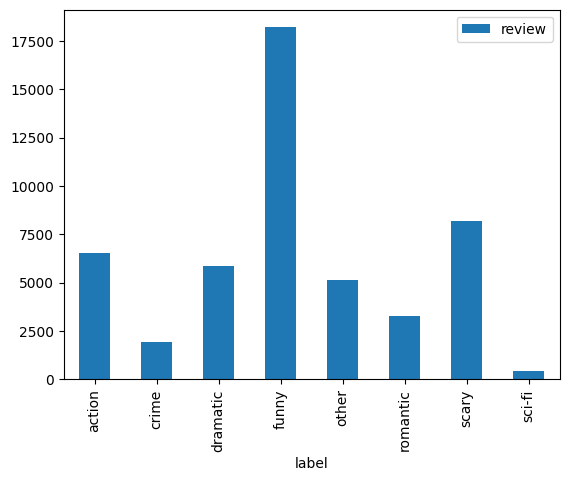

In [129]:
# perform data analysis on imdb_data to see how many reviews are in each category
print(len(imdb_data.groupby('label').count()))

# output a graph / visualization of the data
imdb_data.groupby('label').count().plot.bar(ylim=0)

We notice that sci-fi and crime are the lowest two, so we remove both from our analysis

In [130]:
def label_data_filtered(row):
    keywords = {
        "other": [],
        "funny": ["comedy",
    "humor",
    "wit",
    "satire",
    "parody",
    "joke",
    "prank",
    "playful",
    "entertaining",
    ],
        "scary": ["horror",
    "terror",
    "fear",
    "dread",
    "shock",
    "spooky",
    "haunting",
    "eerie",
    "creepy",
    "frightening",
    "disturbing",
    "chilling",
    "macabre",
    "gory",
    "bloodcurdling",
    "terrifying",
    "horrifying",
    "gothic",
    "sinister",
    "malevolent",
    "ominous",
    "nightmarish",
    "supernatural",
    "paranormal",
    "psychological",
    "slasher",
    "zombie",
    "monster",
    "demon",
    "ghost",
    "witch",
    "vampire",
    "werewolf",
    "scream",
    "jump scare",
    "horror movie",
    "haunted house",
    "horror novel",
    "horror game",
    "psychological thriller"],
        "dramatic": ["drama",
    "intense",
    "serious",
    "emotional",
    "gripping",
    "powerful",
    "poignant",
    "heart-wrenching",
    "heartfelt",
    "compelling",
    "profound",
    "deep",
    "meaningful",
    "thought-provoking",
    "insightful",
    "touching",
    "moving",
    "tragic",
    "melancholy",
    "sorrowful",
    "heavy",
    "profound",
    "probing",
    "triumphant",
    "uplifting",
    "inspiring",
    "motivational",
    "empathetic",
    "sensitive",
    "emotive",
    "soulful",
    "stirring",
    "resonant",
    "gripping",
    "engrossing",
    "character-driven",
    "emotionally charged",
    "powerful performances",
    "Oscar-worthy"],
        "action": ["action",
"adventure",
"thrilling",
"exciting",
"fast-paced",
"intense",
"dangerous",
"explosive",
"suspenseful",
"energetic",
"daring",
"heroic",
"brave",
"bold",
"action-packed",
"fight",
"shootout",
"car chase",
"explosion",
"stunts",
"adrenaline",
"high-octane",
"martial arts",
"spy",
"espionage",
"mission",
"rescue",
"heist",
"battle",
"war",
"combat",
"superhero",
"villain",
"chase scene",
"firefight",
"action hero",
"fast and furious",
"die hard",
"james bond",
"bourne identity",
"avengers",
"marvel"],
        "romantic": ["romance",
    "love",
    "affection",
    "passion",
    "intimacy",
    "sentimental",
    "heartfelt",
    "adorable",
    "cute",
    "charming",
    "endearing",
    "sweet",
    "tender",
    "loving",
    "caring",
    "devoted",
    "committed",
    "romantic comedy",
    "chick flick",
    "heartwarming",
    "swoon-worthy",
    "chemistry",
    "romantic gesture",
    "kiss",
    "romantic dinner",
    "flowers",
    "gifts",
    "love story",
    "tragic romance",
    "fairy tale romance",
    "passionate",
    "emotional",
    "sensual",
    "sexy",
    "intense",
    "deeply romantic",
    "unforgettable",
    "timeless"
    ],
    }

    label_counts = {label: 0 for label in keywords.keys()}
    label_counts['other'] = 0
    review_text = row["review"].lower()

    for label, words in keywords.items():
        if any(word in review_text for word in words):
            label_counts[label] += 1

    first_genre = max(label_counts, key=label_counts.get)
    first_count = label_counts[first_genre]

    label_counts[first_genre] = 0

    second_genre = max(label_counts, key=label_counts.get)
    second_count = label_counts[second_genre]

    return first_genre

6


<Axes: xlabel='label'>

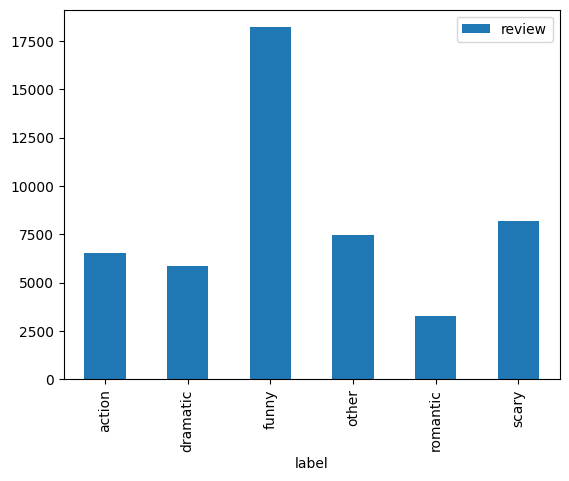

In [132]:
imdb_data['label'] = imdb_data.apply(label_data_filtered
                                     , axis=1)

# perform data analysis on imdb_data to see how many reviews are in each category
print(len(imdb_data.groupby('label').count()))

# output a graph / visualization of the data
imdb_data.groupby('label').count().plot.bar(ylim=0)

In [81]:
train_df = pd.concat([imdb_data, pd.get_dummies(imdb_data['label'], prefix='label')], axis=1)

In [87]:
train_df.drop(columns=['label'], inplace=True)

In [98]:
train_df['review'][0]

'film brilliant casting location scenery story direction everyone really suited part played could imagine robert redford amazing actor director norman father came scottish island loved fact real connection film witty remark throughout film great brilliant much bought film soon released retail would recommend everyone watch fly fishing amazing really cried end sad know say cry film must good definitely also congratulation two little boy played part norman paul brilliant child often left praising list think star play grown big profile whole film child amazing praised done think whole story lovely true someone life shared u'

In [105]:
# Define the number of classes
num_classes = 7

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(train_df['review'])
sequences = tokenizer.texts_to_sequences(train_df['review'])

# Pad the sequences to have the same length
max_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Convert the labels to one-hot encoding
labels = pd.get_dummies(train_df[['label_bad', 'label_dramatic', 'label_funny', 'label_good', 'label_scary']])

# Split the data into training and testing sets
train_size = int(0.8 * len(train_df))
train_data = padded_sequences[:train_size]
train_labels = labels[:train_size].values
test_data = padded_sequences[train_size:]
test_labels = labels[train_size:].values

# Define the model
model = Sequential()
model.add(Embedding(input_dim=10000, output_dim=32))
model.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(units=num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(train_data, train_labels, validation_split=0.1, epochs=5, batch_size=128)

# Evaluate the model
loss, accuracy = model.evaluate(test_data, test_labels)
print("Test accuracy: {:.2f}%".format(accuracy * 100))

Epoch 1/5
279/279 [==============================] - 172s 607ms/step - loss: 1.2760 - accuracy: 0.4714 - val_loss: 1.0720 - val_accuracy: 0.5430
Epoch 2/5
279/279 [==============================] - 177s 634ms/step - loss: 0.8528 - accuracy: 0.6809 - val_loss: 0.6146 - val_accuracy: 0.7464
Epoch 3/5
279/279 [==============================] - 196s 701ms/step - loss: 0.5962 - accuracy: 0.7713 - val_loss: 0.4700 - val_accuracy: 0.8107
Epoch 4/5
279/279 [==============================] - 193s 691ms/step - loss: 0.4209 - accuracy: 0.8520 - val_loss: 0.4442 - val_accuracy: 0.8273
Epoch 5/5
310/310 [==============================] - 24s 79ms/step - loss: 0.2383 - accuracy: 0.9373
Test accuracy: 93.73%


In [110]:
from sklearn.metrics import classification_report

# Get the model's output probabilities for each class
probs = model.predict(test_data)

# Get the predicted class for each sample
pred_classes = np.argmax(probs, axis=1)

# Get the true class for each sample
true_classes = np.argmax(test_labels, axis=1)

# Get the classification report for each class
target_names = ['bad', 'dramatic', 'funny', 'good', 'scary']
print(classification_report(true_classes, pred_classes, target_names=target_names))


310/310 [==============================] - 26s 83ms/step
              precision    recall  f1-score   support

         bad       0.98      0.98      0.98      2187
    dramatic       0.00      0.00      0.00       139
       funny       0.89      0.99      0.94      4449
        good       0.98      0.84      0.90      2310
       scary       0.99      0.96      0.97       831

    accuracy                           0.94      9916
   macro avg       0.77      0.75      0.76      9916
weighted avg       0.93      0.94      0.93      9916



/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [112]:
model2 = Sequential()
model2.add(Embedding(input_dim=10000, output_dim=32))
model2.add(LSTM(units=32, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(units=num_classes, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the class weights
# Convert the labels to one-hot encoding
label_names = ['label_bad', 'label_dramatic', 'label_funny', 'label_good', 'label_scary']
labels = pd.get_dummies(train_df[label_names])
class_weights = {i: 1 for i in range(num_classes)}
class_weights[label_names.index('label_dramatic')] = 2
# Train the model with the class weights
model2.fit(train_data, train_labels, validation_split=0.1, epochs=5, batch_size=128, class_weight=class_weights)

# Evaluate the model
loss, accuracy = model2.evaluate(test_data, test_labels)
print("Test accuracy: {:.2f}%".format(accuracy * 100))

# Calculate the per-class metrics
probs = model2.predict(test_data)
pred_classes = np.argmax(probs, axis=1)
target_names = ['bad', 'dramatic', 'funny', 'good', 'scary']
print(classification_report(np.argmax(test_labels, axis=1), pred_classes, target_names=target_names))

Epoch 1/5
279/279 [==============================] - 174s 614ms/step - loss: 1.3264 - accuracy: 0.4601 - val_loss: 1.0668 - val_accuracy: 0.5306
Epoch 2/5
279/279 [==============================] - 175s 627ms/step - loss: 0.9024 - accuracy: 0.6862 - val_loss: 0.6464 - val_accuracy: 0.7860
Epoch 3/5
279/279 [==============================] - 190s 679ms/step - loss: 0.5900 - accuracy: 0.8299 - val_loss: 0.5712 - val_accuracy: 0.8112
Epoch 4/5
279/279 [==============================] - 189s 678ms/step - loss: 0.3798 - accuracy: 0.9089 - val_loss: 0.2435 - val_accuracy: 0.9430
Epoch 5/5
310/310 [==============================] - 21s 67ms/step - loss: 0.1556 - accuracy: 0.9675
Test accuracy: 96.75%
310/310 [==============================] - 26s 82ms/step
              precision    recall  f1-score   support

         bad       0.99      0.98      0.98      2187
    dramatic       0.50      0.01      0.01       139
       funny       0.95      0.99      0.97      4449
        good       0.98